In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
import quimb as qu
import cotengra as ctg
import autoray as ar
from tcompress import register_ as reg
from tcompress import algo_cooling as algo
from tcompress import quf
import time
import numpy as np
from quimb.tensor.belief_propagation.l2bp import L2BP
from quimb.experimental import tnvmc
from tqdm import tqdm

In [2]:
reg.reg_complex_svd()
import torch
to_backend = algo.backend_torch(device = "cpu", dtype = torch.complex128, requires_grad=False)
to_backend_c = algo.backend_torch(device = "cpu", dtype = torch.complex128, requires_grad=False)

opt = algo.opt_(progbar=False)
# opt = "auto-hq"

In [3]:
#ITF params and Unitary
J, h = 1, 3.05
dt, depth = 0.05, 520
Lx, Ly = 4, 4
L = Lx * Ly


edges = qtn.edges_2d_square(Lx=Lx, Ly=Ly, cyclic=False)
# --- coordinate maps ---
map_1d_to_2d = {j * Lx + i: (i, j) for j in range(Ly) for i in range(Lx)}
map_2d_to_1d = {(i, j): j * Lx + i for j in range(Ly) for i in range(Lx)}


# --- site list ---
site_tags = [f"I{n}" for n in range(L)]
sites = sorted({(map_2d_to_1d[site],) for edge in edges for site in edge})
L = len(sites)
# --- remap edges to 1D indexing ---
edges_1d = [(map_2d_to_1d[x], map_2d_to_1d[y]) for x, y in edges]



In [4]:
mpo_zz = quf.mpo_z_prod(L, "Z", where_= [L//2, L//2 + 1])
mpo_zz.apply_to_arrays(to_backend)

In [5]:
chi = 20
mpoz2 = qtn.MPO_identity(L) * 1.e-12
for i in range(L):
    for j in range(L):
        if i != j:
            mpo_z = quf.mpo_z_prod(L, "Z", where_= [i, j])
        else:
            mpo_z = qtn.MPO_identity(L)

        mpoz2 += mpo_z
        mpoz2.compress("left", max_bond=chi, cutoff=1.e-12 )

mpoz2  /= L**2
mpoz2.apply_to_arrays(to_backend)
mpoz2.show()

│2│3│3│3│3│3│3│3│3│3│3│3│3│3│2│
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │


In [6]:
# rx gate
rx   = to_backend(qtn.circuit.rx_gate_param_gen([-h * dt]))
# rzz gate
rzz = to_backend(qtn.circuit.rzz_param_gen([-2 * J * dt]))

In [7]:
p = qtn.MPS_computational_state(["0"]*L)
info_c = {}
p.canonicalize_([L//2], cur_orthog='calc', info=info_c)
p.apply_to_arrays(to_backend)


chi = 256

F_l = []
t_l = []
z2_l = []
zz_l = []
with tqdm(total=depth,  desc="svd:", leave=True, position=0, 
        colour='CYAN', disable = not True) as pbar:

        for depth_ in range(1, depth+1):

                for count, site in enumerate(sites):
                        p.gate_(rx, site, contract=True)

                for where in edges_1d:
                        p.gate_nonlocal_(rzz, where, max_bond=chi , info=info_c , method='direct', **{"cutoff":1.e-12})
                
                for count, site in enumerate(sites):
                        p.gate_(rx, site, contract=True)
            
                
                
                z2 = quf.energy_global(mpoz2, p)
                zz = quf.energy_global(mpo_zz, p)

                t_l.append( depth_*0.05  )

                
                z2_l.append( complex(z2).real )
                zz_l.append( complex(zz).real )
                pbar.set_postfix({
                        "t":   f"{round(depth_*0.05,2)}",
                        "norm": complex(p.norm()).real,
                        "<Z2>": complex(z2).real,
                        
                        

                })

                pbar.update(1)
pbar.close()



svd:: 100%|██████████| 520/520 [05:33<00:00,  1.56it/s, t=26.0, norm=1, <Z2>=0.282] 


In [8]:
p.norm()

tensor(1.0000-4.8572e-17j, dtype=torch.complex128)

In [12]:
depth_local = 2
params = {'rx_depth0': -0.7892568428716794,
 'rzz_depth0': -0.4765793918718563,
 'rx_depth1': -0.7892712298581741,
 'rzz_depth1': -0.47656342156433745}



# depth_local = 4
# params = {'rx_depth0': -0.3394656463087295,
#  'rzz_depth0': -0.22533130736539966,
#  'rx_depth1': -0.430458916463978,
#  'rzz_depth1': -0.27541617380526684,
#  'rx_depth2': -0.43151334434686744,
#  'rzz_depth2': -0.2750848537925995,
#  'rx_depth3': -0.33473323423765555,
#  'rzz_depth3': -0.2233274482028877}

# depth_local = 5
# params = {'rx_depth0': -0.27945590605909193,
#  'rzz_depth0': -0.19430282164851978,
#  'rx_depth1': -0.34532244835477954,
#  'rzz_depth1': -0.19714061631272767,
#  'rx_depth2': -0.2746343152026875,
#  'rzz_depth2': -0.2135545012300513,
#  'rx_depth3': -0.34841426393206365,
#  'rzz_depth3': -0.1989632677551294,
#  'rx_depth4': -0.2831004013771219,
#  'rzz_depth4': -0.19644717607475115}


p = qtn.MPS_computational_state(["0"]*L)
info_c = {}
p.canonicalize_([L//2], cur_orthog='calc', info=info_c)
p.apply_to_arrays(to_backend)


chi = 256

F_l = []
t_l_ = []
z2_l_ = []
zz_l_ = []
with tqdm(total=depth//10,  desc="svd:", leave=True, position=0, 
        colour='CYAN', disable = not True) as pbar:

        for depth_ in range(1, depth//10+1):


                for local_depth in range(depth_local):
                        rx_param = params[f"rx_depth{local_depth}"]
                        rzz_param = params[f"rzz_depth{local_depth}"]
                        rx   = to_backend(qtn.circuit.rx_gate_param_gen([rx_param]))
                        rzz = to_backend(qtn.circuit.rzz_param_gen([rzz_param]))


                        for count, site in enumerate(sites):
                                p.gate_(rx, site, contract=True)

                        for where in edges_1d:
                                p.gate_nonlocal_(rzz, where, max_bond=chi , info=info_c , method='direct', **{"cutoff":1.e-12})
                        
                        for count, site in enumerate(sites):
                                p.gate_(rx, site, contract=True)
            
                
                
                z2 = quf.energy_global(mpoz2, p)
                zz = quf.energy_global(mpo_zz, p)
                
                t_l_.append( depth_*0.5  )

                
                z2_l_.append( complex(z2).real )
                zz_l_.append( complex(zz).real )
                pbar.set_postfix({
                        "t":   f"{round(depth_*0.5,2)}",
                        "norm": complex(p.norm()).real,
                        "<Z2>": complex(z2).real,
                        
                        

                })

                pbar.update(1)
    
pbar.close()




svd:: 100%|██████████| 52/52 [01:05<00:00,  1.25s/it, t=26.0, norm=1, <Z2>=0.28] 


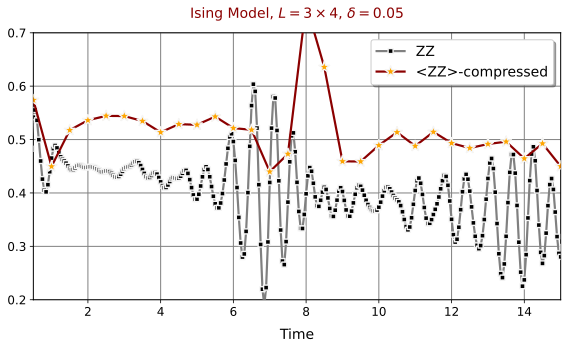

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # compact and clean figure



plt.plot(
    t_l, zz_l, zorder=5, label=r"ZZ",color="gray",
    markersize=5, linewidth=2.2, alpha=1., marker='s', linestyle='-',
    markeredgecolor="whitesmoke", mfc="black", markeredgewidth=1.4
)
plt.plot(
    t_l_, zz_l_, zorder=5, label=r"<ZZ>-compressed",color="darkred",
    markersize=12, linewidth=2.2, alpha=1., marker='*', linestyle='-',
    markeredgecolor="whitesmoke", mfc="orange", markeredgewidth=1.4
)




plt.xlabel("Time", fontsize=14, labelpad=10)
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.5)
plt.tick_params(width=0.8, labelsize=12)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.)

plt.xlim(0.5, 15) 
plt.ylim(0.2, 0.7)


plt.title(rf"Ising Model, $L = {3} \times {4}$, $\delta={0.05}$", fontsize=14, color='darkred', pad=15)  # pad adds space above the plot

plt.grid(color='gray', linestyle='-', linewidth=1., alpha=1.)
plt.legend(loc='best', frameon=True, shadow=True, fontsize=14)
plt.tight_layout()
plt.show()



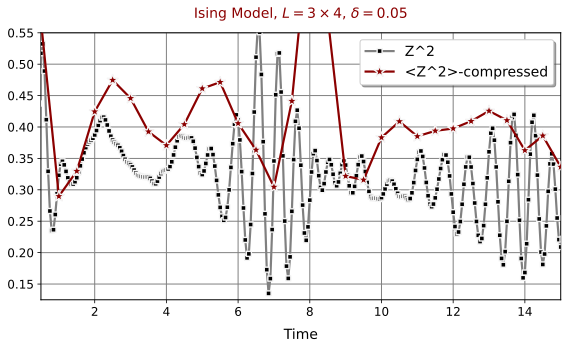

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # compact and clean figure




plt.plot(
    t_l, z2_l, zorder=5, label=r"Z^2",color="gray",
    markersize=5, linewidth=2.2, alpha=1., marker='s', linestyle='-',
    markeredgecolor="whitesmoke", mfc="black", markeredgewidth=1.4
)

plt.plot(
    t_l_, z2_l_, zorder=5, label=r"<Z^2>-compressed",color="darkred",
    markersize=12, linewidth=2.2, alpha=1., marker='*', linestyle='-',
    markeredgecolor="whitesmoke", mfc="darkred", markeredgewidth=1.4
)

plt.xlabel("Time", fontsize=14, labelpad=10)
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.5)
plt.tick_params(width=0.8, labelsize=12)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.)

plt.xlim(0.5, 15) 
plt.ylim(0.125, 0.55)
plt.title(rf"Ising Model, $L = {3} \times {4}$, $\delta={0.05}$", fontsize=14, color='darkred', pad=15)  # pad adds space above the plot

plt.grid(color='gray', linestyle='-', linewidth=1., alpha=1.)
plt.legend(loc='best', frameon=True, shadow=True, fontsize=14)
plt.tight_layout()
plt.show()

